## Assignment 2 - Exploration of patterns in the data

### Energy Demand based on time data

Energy Demand (Regression): Heavily dependant on seasonal patterns (time-of-day, day-of-week, time-of-year), and partly on weather

Descriptive model : Model the relationship between time and demand
Predictive model : Since predicting the time as a given time in the future is trivial, this is almost for free. Different types include Long-term Load Forecasting (months-ahead), Short-term Load Forecasting (day-head or week-ahead), and Ultra Short-term Load Forecasting (hours-ahead).

I have decided explore demand as a function of time features. I will first look at the 

In [3]:
# import what has to be
from influxdb import InfluxDBClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from energy_gen_forecast import mytransformers
plt.style.use('seaborn')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

In [4]:
# create client
client = InfluxDBClient(host = 'influxus.itu.dk', port = 8086, username = 'lsda', password = 'icanonlyread')
client.switch_database('orkney')

In [5]:
client.get_list_measurements()

[{'name': 'ANM_Operation'},
 {'name': 'Demand'},
 {'name': 'Generation'},
 {'name': 'Generator_Site_Issues'},
 {'name': 'SHEPD_Equipment'},
 {'name': 'Temperature'},
 {'name': 'Wind'}]

In [6]:
# get demand data for exploration
results = client.query('SELECT Total FROM "Demand" WHERE time > now() - 200w')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
demand_df = pd.DataFrame(values, columns = columns).set_index("time")

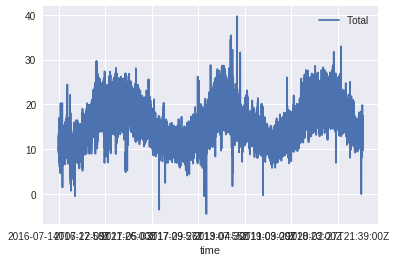

In [5]:
demand_df.plot()

In [6]:
demand_df.head()

,Total
time,
2016-07-14T07:27:58Z,10.54
2016-07-14T07:28:58Z,10.54
2016-07-14T07:29:58Z,10.54
2016-07-14T07:30:58Z,10.54
2016-07-14T07:31:58Z,10.16


In [7]:
results = client.query('SELECT mean(Total) FROM "Demand" WHERE time > now() - 200w GROUP BY time(1h)')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
demand_mean_df = pd.DataFrame(values, columns = columns).set_index("time")

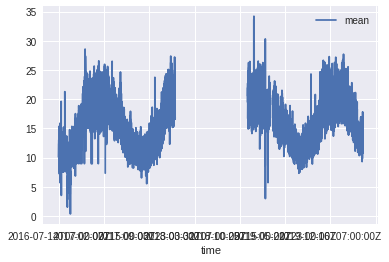

In [8]:
demand_mean_df.plot()

## Preprocessing Pipeline

In [9]:
# preprocessing pipeline
pre_pipeline = Pipeline([
    ('date_worker', mytransformers.DateTransformer()),
    ('shifter', mytransformers.Shifter())
])

In [10]:
# apply pipeline
processed_data = pre_pipeline.fit_transform(demand_df, shifter__days = 7)
features = processed_data[0]
labels = processed_data[0]

In [11]:
features.head()

,time,Total,year,month,day,hour,minute,day_of_week,1dayback,2dayback,3dayback,4dayback,5dayback,6dayback,7dayback
datetime,,,,,,,,,,,,,,,
2018-12-07 11:40:00,2018-12-07T11:40:00Z,21.30,2018,12,7,11,40,4,21.87,22.54,22.93,19.98,20.98,19.55,20.54
2018-12-07 11:50:00,2018-12-07T11:50:00Z,21.62,2018,12,7,11,50,4,21.61,22.51,23.15,20.96,20.92,18.89,20.59
2018-12-07 12:00:00,2018-12-07T12:00:00Z,22.27,2018,12,7,12,0,4,22.37,22.90,23.92,21.15,21.60,20.54,21.50
2018-12-07 12:10:00,2018-12-07T12:10:00Z,23.73,2018,12,7,12,10,4,24.26,25.22,25.86,22.49,23.59,21.87,22.59
2018-12-07 12:20:00,2018-12-07T12:20:00Z,23.29,2018,12,7,12,20,4,23.82,24.58,25.36,22.11,22.83,21.30,22.53


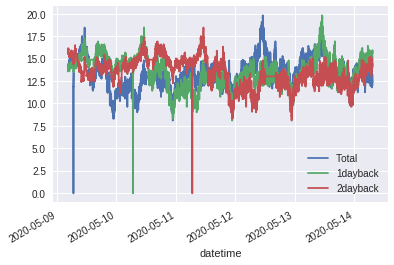

In [12]:
features[['Total', '1dayback', '2dayback']].iloc[-7000:].plot()
plt.savefig('1dayback.png')

In [13]:
trustworthy_test_df = features.groupby(['year', 'month', 'day', 'hour']).count()

In [14]:
trustworthy_test_df[trustworthy_test_df['minute'] != 60]

time  Total  minute  day_of_week  1dayback  2dayback  \
year month day hour                                                         
2018 12    7   11       2      2       2            2         2         2   
               12       6      6       6            6         6         6   
               13       6      6       6            6         6         6   
               14       6      6       6            6         6         6   
               15       6      6       6            6         6         6   
...                   ...    ...     ...          ...       ...       ...   
2020 5     14  0       58     58      58           58        58        58   
               1       34     34      34           34        34        34   
               2       12     12      12           12        12        12   
               3       59     59      59           59        59        59   
               7       27     27      27           27        27        27   

                     3dayback  4dayback  5dayback  6dayback  7dayback  
year month day hour                                                    
2018 12    7   11           2         2         2         2         2  
               12           6         6         6         6         6  
               13           6         6         6         6         6  
               14           6         6         6         6         6  
               15           6         6         6         6         6  
...                       ...       ...       ...       ...       ...  
2020 5     14  0           58        58        58        58        58  
               1           34        34        34        34        34  
               2           12        12        12        12        12  
               3           59        59        59        59        59  
               7           27        27        27        27        27  

[3218 rows x 11 columns]

In [15]:
trustworthy_test_df[trustworthy_test_df['minute'] == 60]

time  Total  minute  day_of_week  1dayback  2dayback  \
year month day hour                                                         
2019 4     3   13      60     60      60           60        60        60   
               14      60     60      60           60        60        60   
               15      60     60      60           60        60        60   
               16      60     60      60           60        60        60   
               17      60     60      60           60        60        60   
...                   ...    ...     ...          ...       ...       ...   
2020 5     13  22      60     60      60           60        60        60   
               23      60     60      60           60        60        60   
           14  4       60     60      60           60        60        60   
               5       60     60      60           60        60        60   
               6       60     60      60           60        60        60   

                     3dayback  4dayback  5dayback  6dayback  7dayback  
year month day hour                                                    
2019 4     3   13          60        60        60        60        60  
               14          60        60        60        60        60  
               15          60        60        60        60        60  
               16          60        60        60        60        60  
               17          60        60        60        60        60  
...                       ...       ...       ...       ...       ...  
2020 5     13  22          60        60        60        60        60  
               23          60        60        60        60        60  
           14  4           60        60        60        60        60  
               5           60        60        60        60        60  
               6           60        60        60        60        60  

[6814 rows x 11 columns]

So most of the time it is correct, but I don't think I can trust this.

## Explorations

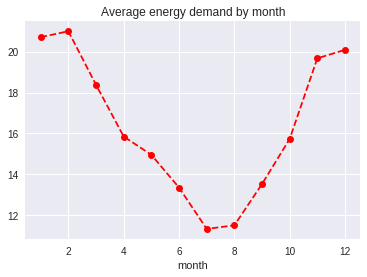

In [16]:
# plot average year
features.groupby(['month']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by month')
plt.savefig('monthly_seasonality.png')

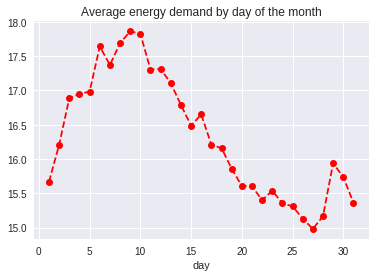

In [17]:
# plot average month
features.groupby(['day']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by day of the month')
plt.savefig('daily_seasonality.png')

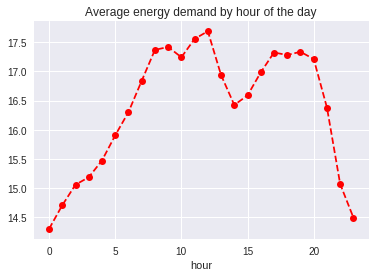

In [18]:
# plot average day
features.groupby(['hour']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by hour of the day')
plt.savefig('hourly_seasonality.png')

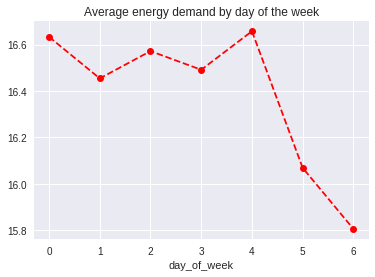

In [19]:
features.groupby(['day_of_week']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by day of the week')
plt.savefig('weekly_seasonality.png')

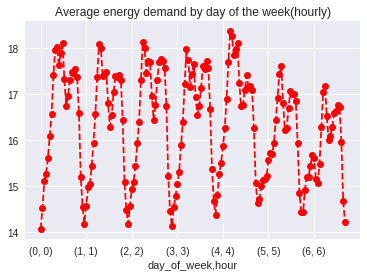

In [20]:
features.groupby(['day_of_week', 'hour']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by day of the week(hourly)')
plt.savefig('weekly_seasonality_hours.png')

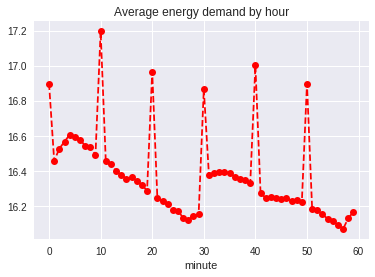

In [21]:
# plot average hour
features.groupby(['minute']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by hour')
plt.savefig('hourly_seasonality.png')

# Is the hourly mean far off from the values

In [22]:
demand_hourly_mean_df = features.groupby(['year', 'month', 'day', 'hour']).mean()['Total']
#for i in range(4)[::-1]:
#    demand_hourly_mean_df = demand_hourly_mean_df.reset_index(level = i)

In [23]:
demand_hourly_mean_df

year  month  day  hour
2018  12     7    11      21.460000
                  12      22.950000
                  13      21.811667
                  14      20.203333
                  15      21.683333
                            ...    
2020  5      14   3       13.922373
                  4       12.973833
                  5       13.387833
                  6       12.953333
                  7       12.571481
Name: Total, Length: 10032, dtype: float64

In [24]:
demand_hourly_std_df = features.groupby(['year', 'month', 'day', 'hour']).std()['Total']

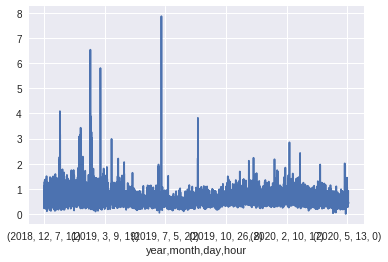

In [25]:
demand_hourly_std_df.plot()

In [26]:
mean_diff_df = features.reset_index(level = 0).set_index(['year', 'month', 'day', 'hour']).join(demand_hourly_mean_df, rsuffix= 'm_')

In [27]:
mean_diff_df['diff_from_mean'] = mean_diff_df['Total'] - mean_diff_df['Totalm_']

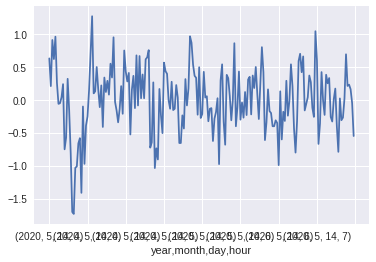

In [28]:
mean_diff_df['diff_from_mean'].iloc[-200:].plot()

In [30]:
mean_absolute_error(mean_diff_df['Total'], mean_diff_df['Totalm_'])

0.4585245671294732

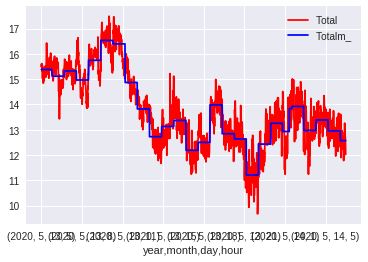

In [31]:
mean_diff_df[['Total', 'Totalm_']].iloc[-1500:].plot(color = ['r', 'b'])
plt.savefig('hourly_mean_vs_actual.png')

In [32]:
np.sqrt(mean_squared_error(mean_diff_df['Total'], mean_diff_df['Totalm_']))

0.6083262122632239

In [33]:
for i in range(4)[::-1]:
    demand_hourly_mean_df = demand_hourly_mean_df.reset_index(level = i)
demand_hourly_mean_df

,year,month,day,hour,Total
0,2018,12,7,11,21.460000
1,2018,12,7,12,22.950000
2,2018,12,7,13,21.811667
3,2018,12,7,14,20.203333
4,2018,12,7,15,21.683333
...,...,...,...,...,...
10027,2020,5,14,3,13.922373
10028,2020,5,14,4,12.973833
10029,2020,5,14,5,13.387833
10030,2020,5,14,6,12.953333


In [7]:
mean_pipeline = Pipeline([
    ('date_worker', mytransformers.DateTransformer()),
    ('aggregator', mytransformers.HourlyAggregator()),
    ('onehot', mytransformers.DummyEncoder()),
    ('dateFeatures', mytransformers.DateTrendsAdder()),
    ('shifter', mytransformers.Shifter())
])

In [8]:
mean_processed = mean_pipeline.fit_transform(demand_df, shifter__days = 7)
mean_features = mean_processed[0].copy()

In [11]:
mean_processed[0][['is_day', 'is_week_day', 'day_of_week', 'distance_from_july']].head(72)

,is_day,is_week_day,day_of_week,distance_from_july
datetime,,,,
2016-07-21 13:00:00,1,1,3,0
2016-07-21 14:00:00,1,1,3,0
2016-07-21 15:00:00,1,1,3,0
2016-07-21 16:00:00,1,1,3,0
2016-07-21 17:00:00,1,1,3,0
...,...,...,...,...
2016-07-24 08:00:00,1,0,6,0
2016-07-24 09:00:00,1,0,6,0
2016-07-24 10:00:00,1,0,6,0


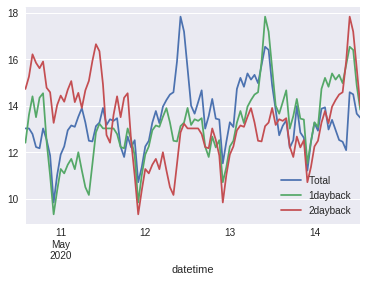

In [12]:
mean_processed[0][['Total', '1dayback', '2dayback']].iloc[-96:].plot()

# Model Building
## Establishing Baseline

In [13]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

## Testing 1 day ahead model

In [22]:
tscv = TimeSeriesSplit(5)
mean_features = mean_processed[0].copy()
labels = mean_features.pop('Total')
base_col_list = ['1dayback', '2dayback', '3dayback', '4dayback', '5dayback', '6dayback', '7dayback']
for train_idx, test_idx in tscv.split(labels):
    print('\nNew Round\n')
    X_train, X_test = mean_features.iloc[train_idx], mean_features.iloc[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    print('Baseline')
    rmse, mae, r2 = eval_metrics(y_test, X_test['1dayback'])
    print(f"rmse: {rmse}")
    print(f"mae: {mae}")
    print(f"r2: {r2}")
    
    X_train = X_train.drop(['1dayback', '2dayback', '3dayback', '4dayback', '5dayback', '6dayback'], axis = 1)
    X_test = X_test.drop(['1dayback', '2dayback', '3dayback', '4dayback', '5dayback', '6dayback'], axis = 1)

    print('\nLasso')
    model = Lasso(0.5).fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse, mae, r2 = eval_metrics(y_test, preds)
    print(f"rmse: {rmse}")
    print(f"mae: {mae}")
    print(f"r2: {r2}")
    for col, val in zip(X_train.columns, model.coef_):
        print(f"{col}\t{val}")

    print('\nRidge')
    model = Ridge(0.5).fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse, mae, r2 = eval_metrics(y_test, preds)
    print(f"rmse: {rmse}")
    print(f"mae: {mae}")
    print(f"r2: {r2}")

    print('\nDecisionTreeRegressor')
    model = DecisionTreeRegressor().fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse, mae, r2 = eval_metrics(y_test, preds)
    print(f"rmse: {rmse}")
    print(f"mae: {mae}")
    print(f"r2: {r2}")
    for col, val in zip(X_train.columns, model.feature_importances_):
        print(f"{col}\t{val}")


	0.0
year_2017	-0.0
year_2018	0.0
year_2019	0.0
year_2020	0.0
month_1	-0.0
month_2	0.0
month_3	0.0
month_4	0.0
month_5	0.0
month_6	0.0
month_7	0.0
month_8	-0.0
month_9	-0.0
month_10	-0.0
month_11	0.0
month_12	-0.0
day_1	0.0
day_2	0.0
day_3	0.0
day_4	0.0
day_5	0.0
day_6	0.0
day_7	0.0
day_8	0.0
day_9	-0.0
day_10	0.0
day_11	-0.0
day_12	-0.0
day_13	0.0
day_14	0.0
day_15	-0.0
day_16	0.0
day_17	-0.0
day_18	0.0
day_19	0.0
day_20	-0.0
day_21	-0.0
day_22	0.0
day_23	-0.0
day_24	-0.0
day_25	-0.0
day_26	-0.0
day_27	-0.0
day_28	0.0
day_29	0.0
day_30	0.0
day_31	0.0
hour_0	-0.0
hour_1	-0.0
hour_2	-0.0
hour_3	-0.0
hour_4	-0.0
hour_5	-0.0
hour_6	-0.0
hour_7	0.0
hour_8	0.0
hour_9	0.0
hour_10	0.0
hour_11	0.0
hour_12	0.0
hour_13	-0.0
hour_14	0.0
hour_15	0.0
hour_16	0.0
hour_17	0.0
hour_18	0.0
hour_19	0.0
hour_20	0.0
hour_21	-0.0
hour_22	-0.0
hour_23	-0.0
day_of_week_0	0.0
day_of_week_1	0.0
day_of_week_2	-0.0
day_of_week_3	-0.0
day_of_week_4	0.0
day_of_week_5	0.0
day_of_week_6	0.0
distance_from_july	0.9718

In [23]:
from tensorflow import keras

In [47]:
mean_features = mean_processed[0].copy()
corr_with_total = mean_features.corr(method = 'pearson')['Total'].sort_values()

In [53]:
corr_with_total[corr_with_total >  0.15]

year_2020             0.162896
month_3               0.166058
year_2018             0.168361
year                  0.207101
month_2               0.222094
is_day                0.235534
month_11              0.263872
month_1               0.306193
month_12              0.310857
distance_from_july    0.774545
5dayback              0.807254
6dayback              0.811104
7dayback              0.817134
4dayback              0.819273
3dayback              0.821368
2dayback              0.831770
1dayback              0.874511
Total                 1.000000
Name: Total, dtype: float64

In [55]:
corr_with_total[corr_with_total <  -0.15]

month_8     -0.359883
month_7     -0.345708
month_9     -0.258050
month_6     -0.199558
year_2016   -0.172079
Name: Total, dtype: float64